In [1]:
%matplotlib inline


Audio Feature Augmentation
==========================


In [2]:
import torch
import torchaudio
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.13.0+cu117
0.13.0+cu117


Preparing data and utility functions (skip this section)
--------------------------------------------------------




In [4]:
# @title Prepare data and utility functions. {display-mode: "form"}
# @markdown
# @markdown You do not need to look into this cell.
# @markdown Just execute once and you are good to go.
# @markdown
# @markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/),
# @markdown which is licensed under Creative Commos BY 4.0.

# -------------------------------------------------------------------------------
# Preparation of data and helper functions.
# -------------------------------------------------------------------------------

import os

import librosa
import matplotlib.pyplot as plt
import requests


_SAMPLE_DIR = "_assets"

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

os.makedirs(_SAMPLE_DIR, exist_ok=True)


def _fetch_data():
    uri = [
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    ]
    for url, path in uri:
        with open(path, "wb") as file_:
            file_.write(requests.get(url).content)


_fetch_data()


def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)


def get_spectrogram(
    n_fft=400,
    win_len=None,
    hop_len=None,
    power=2.0,
):
    waveform, _ = get_speech_sample()
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
    )
    return spectrogram(waveform)


def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

SpecAugment
-----------

`SpecAugment <https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html>`__
is a popular spectrogram augmentation technique.

``torchaudio`` implements :py:func:`torchaudio.transforms.TimeStretch`,
:py:func:`torchaudio.transforms.TimeMasking` and
:py:func:`torchaudio.transforms.FrequencyMasking`.




TimeStretch
-----------




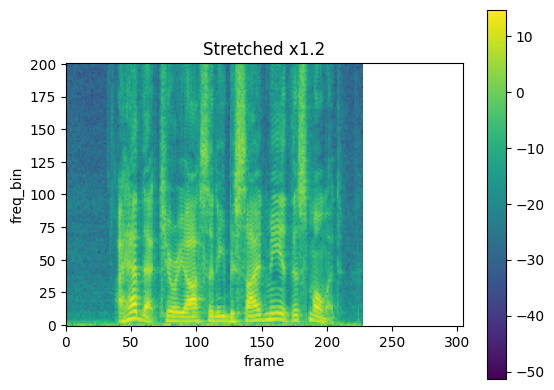

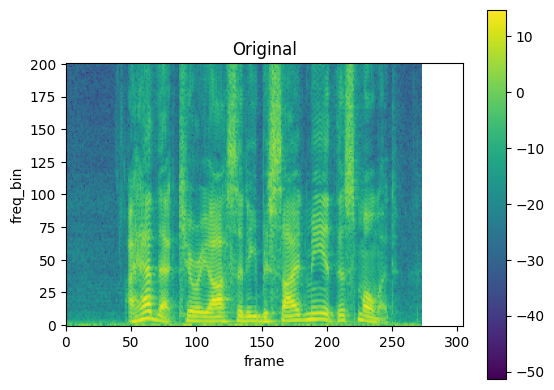

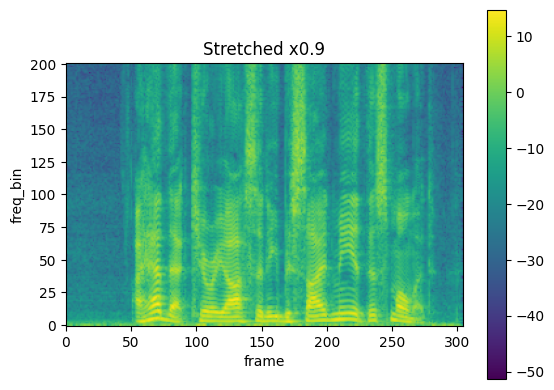

In [5]:
spec = get_spectrogram(power=None)
stretch = T.TimeStretch()

rate = 1.2
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect="equal", xmax=304)

plot_spectrogram(torch.abs(spec[0]), title="Original", aspect="equal", xmax=304)

rate = 0.9
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect="equal", xmax=304)

TimeMasking
-----------




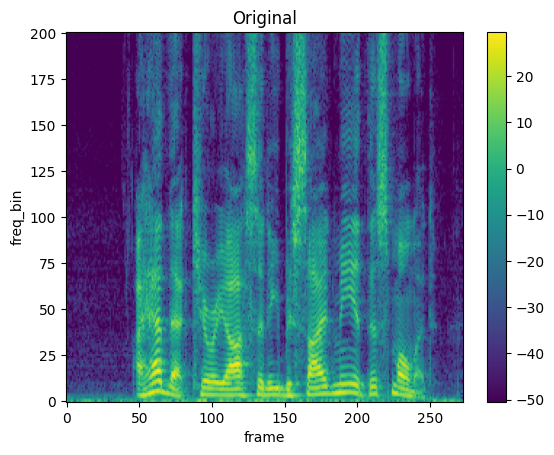

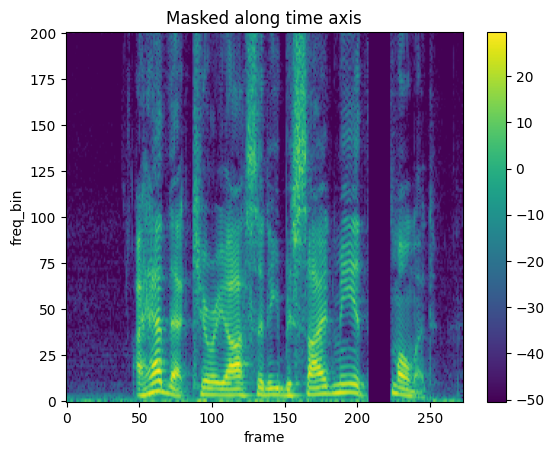

In [40]:
torch.random.manual_seed(106)
#시드 설정에 따라 마스크 하는 부분이 달라진다. 마스크 이미지가 여러장 필요할 경우 여기서 시드값을 조정하면된다.

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.TimeMasking(time_mask_param=80)
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along time axis")

FrequencyMasking
----------------




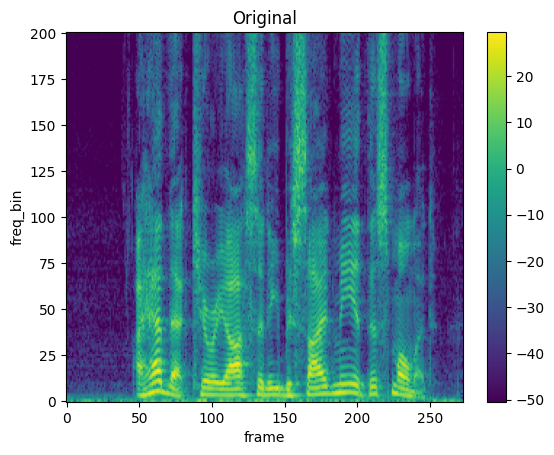

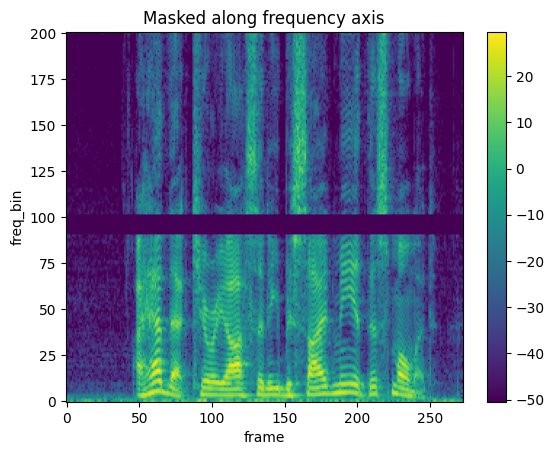

In [42]:
torch.random.manual_seed(11)

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.FrequencyMasking(freq_mask_param=80)
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along frequency axis")

## Time masking and FrequencyMasking

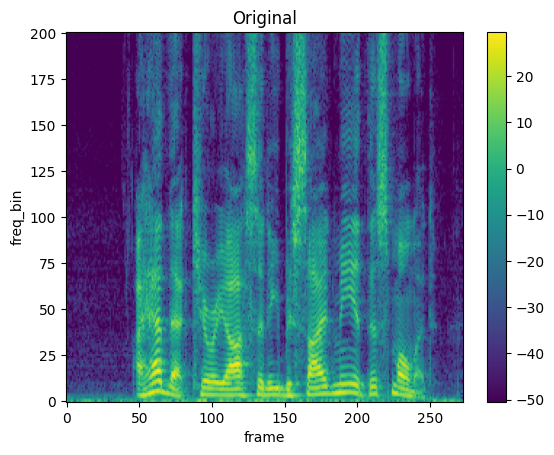

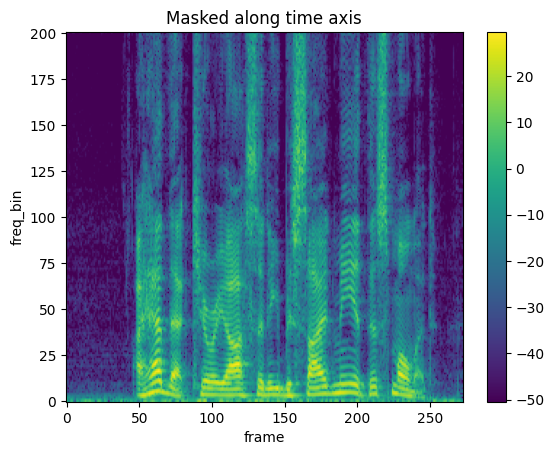

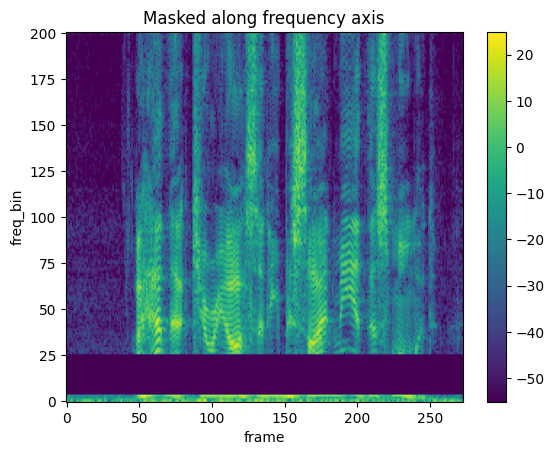

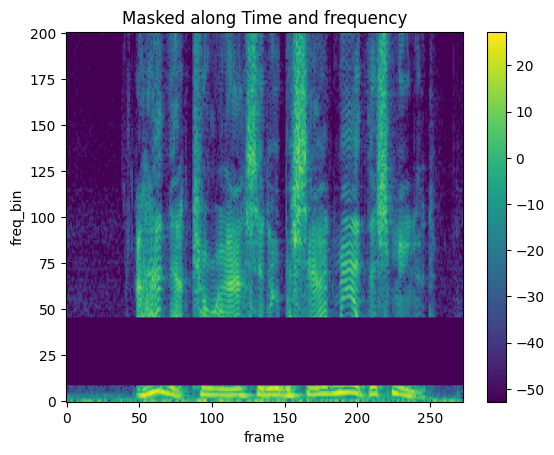

In [51]:
torch.random.manual_seed(3)
#시드 설정에 따라 마스크 하는 부분이 달라진다. 마스크 이미지가 여러장 필요할 경우 여기서 시드값을 조정하면된다.

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

T_masking = T.TimeMasking(time_mask_param=80)
tspec = T_masking(spec)

plot_spectrogram(tspec[0], title="Masked along time axis")

F_masking = T.FrequencyMasking(freq_mask_param=80)
fspec = F_masking(spec)

plot_spectrogram(fspec[0], title="Masked along frequency axis")

masking = T.FrequencyMasking(freq_mask_param=80)
tfspec = masking(tspec)

plot_spectrogram(tfspec[0], title="Masked along Time and frequency")